In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import (
    color, filters, exposure, measure, morphology, transform, util)
from segmentflow import segment, view
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load images

Data shape:  (2187, 1691, 1596)
Data type:  uint8


  0%|          | 0/219 [00:00<?, ?it/s]

Rescaled type:  uint8
Rescaled shape:  (219, 169, 160)
--> Plotting images: [50, 100, 150]


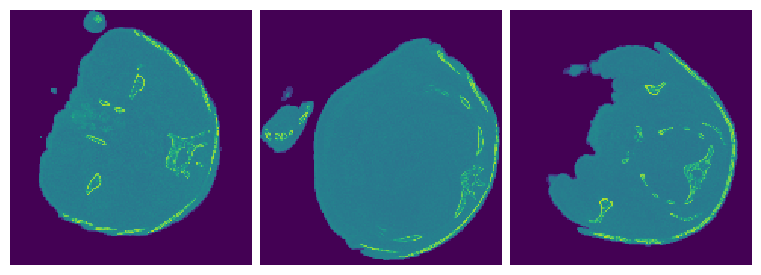

In [40]:
# imgs_path = Path('armadillo-UF20650')
# imgs = segment.load_images(
#     imgs_path,
#     slice_crop=None,
#     file_suffix='.tif'
# )
# print('Data type: ', imgs.dtype)
# imgs = util.img_as_ubyte(imgs)
print('Data shape: ', imgs.shape)
print('Data type: ', imgs.dtype)
# imgs = transform.rescale(imgs, 0.5, anti_aliasing=False)
scale = 10
img0 = transform.rescale(imgs[0, ...], 1/scale, anti_aliasing=False)
imgs_rs = np.zeros(
    (imgs.shape[0]//scale + 1, img0.shape[0], img0.shape[1]), dtype=np.uint8)
for new_i, og_i in enumerate(tqdm(range(0, imgs.shape[0], scale))):
    img_rs = transform.rescale(imgs[og_i, ...], 1/scale, anti_aliasing=False)
    imgs_rs[new_i, ...] = util.img_as_ubyte(img_rs)
print('Rescaled type: ', imgs_rs.dtype)
print('Rescaled shape: ', imgs_rs.shape)
# imgs = transform.resize(
#     imgs,
#     (imgs.shape[0]//2, imgs.shape[1]//2, imgs.shape[2]//2), anti_aliasing=False)
# slices = [250, 500, 750]
slices = [50, 100, 150]
fig, axes = view.plot_slices(
    imgs_rs,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

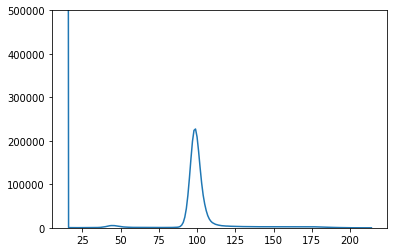

In [44]:
hist, bins_centers = exposure.histogram(imgs_rs)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.set_ylim([0, 5e5])
plt.show()

## Semantic seg

--> Plotting images: [50, 100, 150]


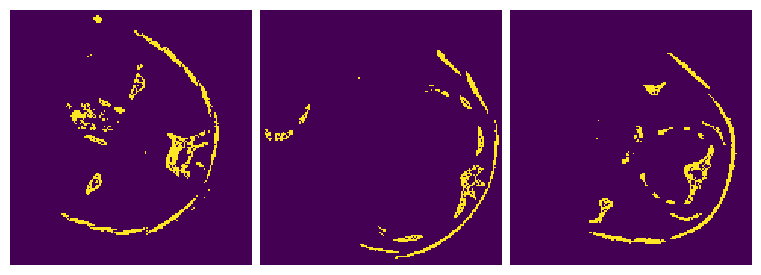

In [45]:
thresholds = [110]
imgs_semantic = segment.isolate_classes(imgs_rs, thresholds)
fig, axes = view.plot_slices(imgs_semantic, slices=slices)
plt.show()

In [46]:
pts = np.array(np.nonzero(imgs_semantic))
pts.shape

In [50]:
df = pd.DataFrame(pts.T, columns=['z', 'y', 'x'])
df.head()

,z,y,x
0,2,73,68
1,2,74,69
2,2,76,70
3,2,77,70
4,2,77,72


In [51]:
df.to_csv(f'amardillo-{scale}scale.csv', index=False)

## Instance seg

Segmenting images...
--> Number of particle(s) before border exclusion:  16526
--> Excluding border particles...
--> Segmentation complete. 15662 particle(s) segmented.


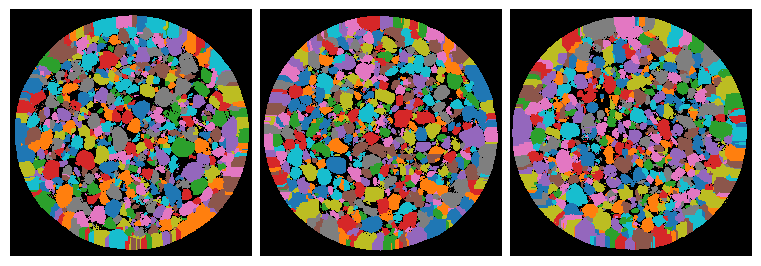

In [9]:
imgs = None
imgs_med = None
imgs_res = None
imgs_labeled = segment.watershed_segment(
    imgs_semantic==len(thresholds),
    min_peak_distance=6,
    exclude_borders=True,
    return_dict=False
)
fig, axes = view.plot_color_labels(
    imgs_labeled,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

In [25]:
imgs_labeled_unique = np.unique(imgs_labeled)
print(f'{imgs_labeled_unique.shape=}')
print(f'{imgs_labeled_unique[:10]=}')

imgs_labeled_unique.shape=(15663,)
imgs_labeled_unique[:10]=array([  0, 645, 646, 647, 651, 652, 653, 654, 655, 656], dtype=uint16)


In [10]:
merged_labels_dir_path = Path('../results/F83_01_merged_labels')
imgs_merged = segment.merge_segmentations(imgs_semantic, imgs_labeled)
segment.save_images(imgs_merged, merged_labels_dir_path)

996 image(s) saved to: C:\Users\gusb\Research\mhe-analysis\nbs\results\F83_01_merged_labels


Loading images...
--> Images loaded as 3D array:  (996, 1014, 994)


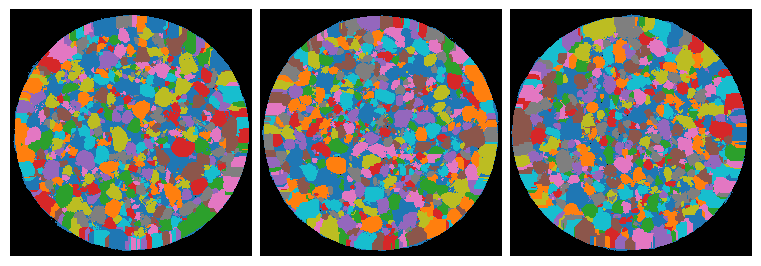

In [29]:
merged_labels_dir_path = Path('C:/Users/gusb/Documents/00-research-docs/F83_01_merged_labels')
imgs_merged = segment.load_images(merged_labels_dir_path, file_suffix='.tif')
fig, axes = view.plot_color_labels(
    imgs_merged,
    slices=slices,
    fig_w=7.5,
    dpi=100
)
plt.show()

In [30]:
imgs_merged_unique = np.unique(imgs_merged)
print(f'{imgs_merged_unique.shape=}')
print(f'{imgs_merged_unique[:10]=}')
print(f'{imgs_merged_unique[-1]=}')

imgs_merged_unique.shape=(15664,)
imgs_merged_unique[:10]=array([  0,   1, 645, 646, 647, 651, 652, 653, 654, 655], dtype=uint16)
imgs_merged_unique[-1]=16526
